### Importing the required libraries ###

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import zipfile


### UNZIP files ###

In [44]:
# # Will unzip the files so that you can see them..
# with zipfile.ZipFile("input/train.csv.zip","r") as z:
#     z.extractall(".")


In [45]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/working/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

### Reading the Train File ###

In [46]:
# prepare text samples and their labels
print('Loading in comments...')

data = pd.read_csv("input/train.csv")
print(data.head())

Loading in comments...
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
# Feature Imformation 
data.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
# Data Dimension 

data.shape 

(159571, 8)

In [7]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [8]:
# Check Missing Value 

print(data["comment_text"].isna().sum())

# dropna 

0


In [9]:
# check missing values in numeric columns
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
unlabelled_in_all = data[(data['toxic']!=1) & (data['severe_toxic']!=1) &
                             (data['obscene']!=1) & (data['threat']!=1) &
                             (data['insult']!=1) & (data['identity_hate']!=1)]
print('Percentage of unlabelled comments or good comments is ', len(unlabelled_in_all)/len(data)*100)

Percentage of unlabelled comments or good comments is  89.83211235124176


In [11]:
labelled_in_all = data[(data['toxic']==1) & (data['severe_toxic']==1) &
                             (data['obscene']==1) & (data['threat']==1) &
                             (data['insult']==1) & (data['identity_hate']==1)]
print('Percentage of comments which is present in all categories is ', len(labelled_in_all)/len(data)*100)

Percentage of comments which is present in all categories is  0.019427088882065038


In [12]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in train is {}'.format(len(data)))
print(data[cols_target].sum())

Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


Next, let's examine the correlations among the target variables.

<AxesSubplot:title={'center':'Correlation of features & targets'}>

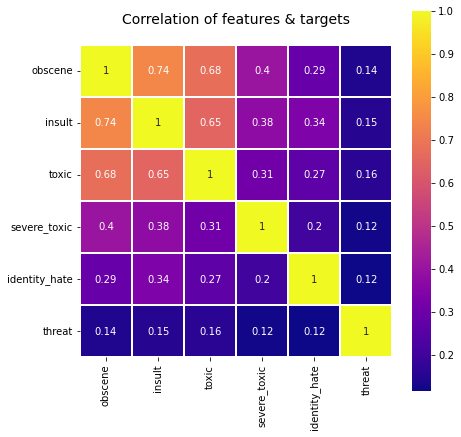

In [13]:
target_data = data[cols_target]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(target_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

### Now this kind of problem is ###

1) Multi class problem and not Binary

2) Also all classes are not independent but rather dependent or correlated 

3) A comment can belong to multiple classes at the same time for e.g. comment can be toxic and insulting at the same time

Let us simplify the problem by first classifying the comments as "block" vs "allow" 

In [14]:
data['block'] =data[cols_target].sum(axis =1)

data['block'] = data['block'] > 0 
data['block'] = data['block'].astype(int)
data['block'].value_counts()


0    143346
1     16225
Name: block, dtype: int64

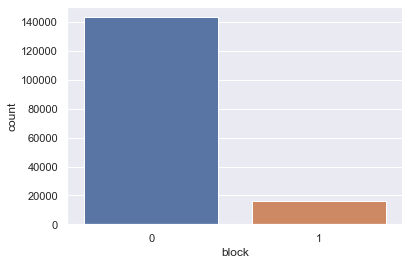

In [15]:
# look at the count plot for text length
sns.set()
sns.countplot(x="block" , data = data )
plt.show()

In [16]:
# Event Rate 

print("Percentage Event Rate : " , round(100*data['block'].sum()/data.shape[0],2) , "%")

Percentage Event Rate :  10.17 %


### Let us focus on comments  ###

In [17]:
# Let's look at the character length for the rows in the training data and record these
data['char_length'] = data['comment_text'].apply(lambda x: len(str(x)))

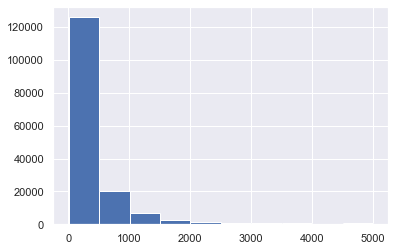

In [18]:
# look at the histogram plot for text length
sns.set()
data['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.



### Clean the Comments Text ###

In [19]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [20]:
%%time 
data['comment_text'] = data['comment_text'].map(lambda com : clean_text(com))

Wall time: 7.3 s


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['comment_text'], data['block'], test_size=0.2, random_state=42)

In [22]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(127656,) (31915,)
(127656,) (31915,)


In [23]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features = 10000, stop_words='english')
print(vect)

TfidfVectorizer(max_features=10000, stop_words='english')


In [24]:
%%time 
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_dtm

Wall time: 4.61 s


<127656x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2792162 stored elements in Compressed Sparse Row format>

In [25]:
3222899/ (127656*165867)

0.00015221080188127105

In [26]:
%%time
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_dtm = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_dtm

Wall time: 1.03 s


<31915x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 688258 stored elements in Compressed Sparse Row format>

## Lets us build a binary classifier using Logistic Regression ##

In [27]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logreg = LogisticRegression(C=1, max_iter = 2000)



# train the model using X_train_dtm & y_train
logreg.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = logreg.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = logreg.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))


Training accuracy is 0.9594613649182178
Test accuracy is 0.9563214789284036
[[28507   164]
 [ 1230  2014]]


# Welcome to the curse of Accuracy, F1(help) to the rescue #

In [28]:
from sklearn.metrics import f1_score


print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))
    


F1 score on Test data :  0.7428992991516045


### In case of Class Imbalance - we use F1 score as a general measure for the model performance ###

Depending on the Business case - we need to fine tune the model 

There is a Precision vs Recall Trade off 

If you want to capture all toxic tweets  - then some of the good comments will be misclassified as bad comments 

In [29]:
y_pred_test = logreg.predict_proba(X_test_dtm)[:,1]
#print(y_pred_test)
y_pred_test = y_pred_test >= 0.2 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.9515588281372396
[[27777   894]
 [  652  2592]]
F1 score on Test data :  0.7702823179791977


# Let us use a tree base model #

In [30]:
%%time 

from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier 

dt_clf = DecisionTreeClassifier()
# train the model using X_train_dtm & y_train
dt_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = dt_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = dt_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9987701322303691
Test accuracy is 0.9417201942660192
[[27815   856]
 [ 1004  2240]]
F1 score on Test data :  0.7066246056782335
Wall time: 2min 38s


### Lets us try an Ensemble of Trees ###

In [31]:
%%time 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

rf_clf = RandomForestClassifier()

# train the model using X_train_dtm & y_train
rf_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = rf_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = rf_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9987544651250235
Test accuracy is 0.95770014099953
[[28291   380]
 [  970  2274]]
F1 score on Test data :  0.7711088504577823
Wall time: 4min 36s


In [32]:
# Fine Tuning Random Forest 

y_pred_test = rf_clf.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.05 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.806078646404512
[[22670  6001]
 [  188  3056]]
F1 score on Test data :  0.496870173156654


In [33]:
%%time
from sklearn.metrics import f1_score
from sklearn.linear_model  import PassiveAggressiveClassifier 

pa_clf = PassiveAggressiveClassifier()

# train the model using X_train_dtm & y_train
pa_clf.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = pa_clf.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = pa_clf.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9755436485554929
Test accuracy is 0.951496161679461
[[28014   657]
 [  891  2353]]
F1 score on Test data :  0.7524784138151583
Wall time: 295 ms


### Passive Aggresive Classifier does not support prediction probability - so can't be fined ###

In [39]:
!pip install xgboost

In [34]:
%%time 
from sklearn.metrics import f1_score
import xgboost 

xgb = xgboost.XGBClassifier()
# train the model using X_train_dtm & y_train
xgb.fit(X_train_dtm, y_train)
# compute the training accuracy
y_pred_train = xgb.predict(X_train_dtm)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
# compute the predicted probabilities for X_test_dtm
y_pred_test = xgb.predict(X_test_dtm)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Training accuracy is 0.9605032274237012
Test accuracy is 0.9544414851950493
[[28513   158]
 [ 1296  1948]]
F1 score on Test data :  0.7282242990654205
Wall time: 13.6 s


In [35]:
# Fine Tuning XGBOOST

y_pred_test = xgb.predict_proba(X_test_dtm)[:,1]
y_pred_test = y_pred_test >= 0.06 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.8847877173742754
[[25405  3266]
 [  411  2833]]
F1 score on Test data :  0.6064433265546398


### Advance Models - LightGBM ### 

In [43]:
!pip install lightgbm

In [36]:
import lightgbm 

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

train_data = lightgbm.Dataset(X_train_dtm, label=y_train)
test_data = lightgbm.Dataset(X_test_dtm, label=y_test)

clf = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=500,
                       early_stopping_rounds=10)






C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.925447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.799381
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.842415
[3]	valid_0's auc: 0.866246
[4]	valid_0's auc: 0.872495
[5]	valid_0's auc: 0.884018
[6]	valid_0's auc: 0.887705
[7]	valid_0's auc: 0.888553
[8]	valid_0's auc: 0.893005
[9]	valid_0's auc: 0.892921
[10]	valid_0's auc: 0.894356
[11]	valid_0's auc: 0.895582
[12]	valid_0's auc: 0.895666
[13]	valid_0's auc: 0.895692
[14]	valid_0's auc: 0.896003
[15]	valid_0's auc: 0.896534
[16]	v

[260]	valid_0's auc: 0.956169
[261]	valid_0's auc: 0.95624
[262]	valid_0's auc: 0.956258
[263]	valid_0's auc: 0.956347
[264]	valid_0's auc: 0.956395
[265]	valid_0's auc: 0.956434
[266]	valid_0's auc: 0.956426
[267]	valid_0's auc: 0.956478
[268]	valid_0's auc: 0.956564
[269]	valid_0's auc: 0.956583
[270]	valid_0's auc: 0.956605
[271]	valid_0's auc: 0.956609
[272]	valid_0's auc: 0.956653
[273]	valid_0's auc: 0.9567
[274]	valid_0's auc: 0.956736
[275]	valid_0's auc: 0.956757
[276]	valid_0's auc: 0.956782
[277]	valid_0's auc: 0.956791
[278]	valid_0's auc: 0.956838
[279]	valid_0's auc: 0.956871
[280]	valid_0's auc: 0.956905
[281]	valid_0's auc: 0.957035
[282]	valid_0's auc: 0.957124
[283]	valid_0's auc: 0.957124
[284]	valid_0's auc: 0.957142
[285]	valid_0's auc: 0.957215
[286]	valid_0's auc: 0.957275
[287]	valid_0's auc: 0.957295
[288]	valid_0's auc: 0.957297
[289]	valid_0's auc: 0.957286
[290]	valid_0's auc: 0.957318
[291]	valid_0's auc: 0.957341
[292]	valid_0's auc: 0.957352
[293]	valid_0

In [37]:
# Fine Tuning LIGHT GBM

y_pred_test = clf.predict(X_test_dtm)
y_pred_test = y_pred_test >= 0.35 # by default it is 0.5
y_pred_test = y_pred_test.astype(int)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print("F1 score on Test data : " ,f1_score(y_test,y_pred_test))

Test accuracy is 0.899138336205546
[[25799  2872]
 [  347  2897]]
F1 score on Test data :  0.642849217796516


## Model Explanation ##

In [39]:
!pip install eli5 --user

  Using cached eli5-0.13.0-py2.py3-none-any.whl
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.1-cp39-cp39-win_amd64.whl (17 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires Jinja2<3.0.0, but you have jinja2 3.1.2 which is incompatible.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 2.1.1 which is incompatible.


In [40]:
import eli5

eli5.show_weights(logreg,vec = vect, top = 15)  # logistic regression
# will give you top 15 features or words  which makes a comment toxic 

Weight?,Feature
+16.643,fuck
+13.475,fucking
+12.117,shit
+11.670,idiot
+11.024,stupid
+10.370,ass
+9.229,asshole
+8.903,bullshit
+8.776,suck
+8.692,bitch


In [41]:
eli5.show_weights(xgb,vec = vect,top = 15)  # XGBoost
# will give you top 15 features or words  which makes a comment toxic 

Weight,Feature
0.0273,fuck
0.0153,fucking
0.0128,faggot
0.0128,dick
0.0126,suck
0.0114,asshole
0.0105,penis
0.0105,fat
0.0103,bitch
0.0102,shit


## Explanation ##

In [42]:
X_test.iloc[718]

'by the way the exchange between rjensen is jpgordon is a sock puppet conversation pathetic really 129 133 127 244'

In [43]:
eli5.show_prediction(logreg, vec = vect, doc =  X_test.iloc[718]) 